# Neural & Behavioral Modeling - Week 11 (Exercises)
by Ting-Yu, Lin (tylin.amice@gmail.com)

In [1]:
# Upgrade PyTorch to 0.4.0 if necessary:
! conda install -y pytorch-cpu torchvision-cpu -c pytorch

Solving environment: done

## Package Plan ##

  environment location: /raid/opt/hpc/anaconda/python3

  added / updated specs: 
    - pytorch-cpu
    - torchvision-cpu


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pytorch-cpu-0.4.0          |       py36_cpu_1        48.9 MB  pytorch
    torchvision-cpu-0.2.1      |           py36_1         123 KB  pytorch
    ------------------------------------------------------------
                                           Total:        49.1 MB

The following NEW packages will be INSTALLED:

    pytorch-cpu:     0.4.0-py36_cpu_1 pytorch
    torchvision-cpu: 0.2.1-py36_1     pytorch


pytorch-cpu 0.4.0####################################################### | 100% 
torchvision-cpu 0.2.1################################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: failed
ERROR conda.core.

In [120]:
#check server status
! nvidia-smi

Tue May 15 14:10:17 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 20%   43C    P8    20W / 250W |  10627MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
| 20%   34C    P8    17W / 250W |  10627MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np

In [164]:
# Check GPU status:
import torch as t
print('PyTorch version:',t.__version__)
if(t.cuda.is_available()):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
else:
    print('No GPU')

PyTorch version: 0.4.0
Device  0 : TITAN V
Device  1 : GeForce GTX 1080 Ti
Device  2 : GeForce GTX 1080 Ti
Device  3 : GeForce GTX 1080 Ti
Current: Device  0


## 1 Tuning the performance of a neural net (10 points)

### 1.1 Problem
In the section 4.1 of 11_examples.ipynb, the neural network implemented in NumPy with two hidden layers could reach 90% classification accuracy on the MNIST training data only within 3 learning epochs:

<pre>
model=MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100], output_size=10,
                          weight_init_std=weight_init_std, use_batchnorm=True, use_dropout=True)
</pre>

However, in the section 4.2, a similar network implemented in PyTorch did not reached 90% clasification accuracy model on the MNIST training data until 350 learning epochs: 

<pre>
model = t.nn.Sequential(
    t.nn.Linear(D_in, H),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    #t.nn.Dropout(p=0.5),
    t.nn.Linear(H, H),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    #t.nn.Dropout(p=0.5),
    t.nn.Linear(H, D_out),
    t.nn.Softmax()
)
</pre>

Your goal is to do whatever you can to help the PyTorch net reach 90% classification accuracy on the MNIST training data within 50 or less epochs.

### 1.2 Tips

First try to eliminate the differences between the NumPy net and the PyTorch net:

(1) The PyTorch version did not use 50% Dropout.

(2) The PyTorch used Adam with a learning rate of 1e-4 as an optimizer instead of SGD with a learning rate of 1e-2.

(3) The PyTroch version did not use shuffled batch (100 samples) in each training epoch.

(4) The NumPy version used He initialization on NORMAL W and ZEROED b:
<pre>
    def __init_weight(self, weight_init_std):

        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                <font color="red">scale = np.sqrt(2.0 / all_size_list[idx - 1])  # for ReLu</font>
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # for Sigmoid
            <font color="blue">self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])</font>
</pre>

However, the PyTroch version used Xavier initialization on UNIFORM W and b for <a href="https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L44-L48">linear layers</a>:

<pre>
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        <font color="red">self.reset_parameters()</font>
<font color="blue">
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
</font>
</pre>

(5)If removal of the above differences does not help, look for other differences or do whatever you can to accelerate learning of the PyTorch net.

<b>(6) Do not waste your time on checking out training results after 50 epochs! They have nothing to do with your goal here.</b>

### 1.3 Your codes and discussions

小結論: <br>
把tips都調過之後, 使用Adam當optimizer, learning_rate設1e-1, 可以讓epoch 50時準確率上到0.9.<br>
以下為依序將Numpy版本和Pytorch版本code差異減少的結果.(疊加)<br>

(0) 一開始的code大概在epoch 50時準確率0.6~0.7

(1) 加入dropout後在epoch 50時準確率0.4~0.5

(2) 改成SGD, 並設learning rate = 1e-1, 則準確率約在0.2~0.3. *:在這個階段, 反過來以準確率到0.90以上為目標調整learning rate, 則learning rate要調到2.8左右才能讓準確率達到0.9左右. 

(3) 加入shuffled batch( batch size = 100)之後準確率約在0.2~0.3

(4) Numpy版本是每一層的weight一起normalize, 但在pytorch版本有點不知道怎麼改. 所以試了每一層的Weight normalization + bias=False, 這個對準確率也沒有特別有幫助(約在0.2左右)<br>

(code參考: https://discuss.pytorch.org/t/how-to-use-torch-nn-init-normal-with-nn-linear/5828)

Torch NN tutorial: https://ckmarkoh.github.io/blog/2016/12/19/torch-nn-tutorial-1-nn-module/

#### 1.3.1 The MNIST dataset

In [3]:
# Download the dataset:
import urllib.request
urllib.request.urlretrieve('http://deeplearning.net/data/mnist/mnist.pkl.gz','mnist.pkl.gz')

('mnist.pkl.gz', <http.client.HTTPMessage at 0x2b1604cc6e80>)

/raid/opt/hpc/anaconda/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: invalid escape sequence '\>'
  after removing the cwd from sys.path.
/raid/opt/hpc/anaconda/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: invalid escape sequence '\?'
  after removing the cwd from sys.path.


(50000, 784) (50000,) (10000, 784) (10000,)
0.0 0.99609375 0 9


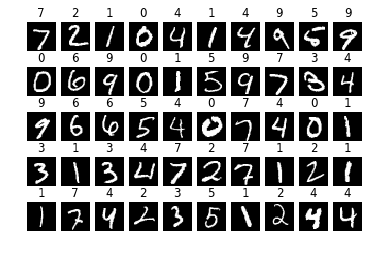

In [152]:
# Load the dataset:
import pickle, gzip
f = gzip.open('mnist.pkl.gz','rb')
train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')
f.close()

x_train,y_train=train_set[0],train_set[1]
x_valid,y_valid=valid_set[0],valid_set[1]
x_test,y_test=test_set[0],test_set[1]

# Examine the dataset:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
print(np.min(x_train),np.max(x_train),np.min(y_train),np.max(y_train))
for i in range(50):
    subplot(5,10,i+1)
    imshow(x_test[i].reshape([28,28]),cmap='gray');
    title(str(y_test[i]));
    axis('off')
    
# Transform NumPy arrays to PyTorch tensors:
use_cuda=t.cuda.is_available()

X_train=t.from_numpy(x_train)
Y_train=t.from_numpy(y_train)
X_test=t.from_numpy(x_test)
Y_test=t.from_numpy(y_test)



if(use_cuda):
    X_train=X_train.cuda()
    Y_train=Y_train.cuda()
    X_test=X_test.cuda()
    Y_test=Y_test.cuda()

#### 1.3.2 Your systematic explorations

In [189]:
# Here is the PyTorch net:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.

            
D_in,H,D_out=784,100,10
batch_size = 5000
train_size = x_train.shape[0]

#batch_mask = np.random.choice(train_size, batch_size)
#X_batch = X_train[batch_mask]
#Y_batch = Y_train[batch_mask]



# normal init
l1 = t.nn.Linear(D_in, H, bias=False)
t.nn.init.normal(l1.weight)
#l = torch.nn.Linear(5,10)
#torch.nn.init.kaiming_normal(l.weight)
#torch.nn.init.normal(l.bias)

l2 = t.nn.Linear(H, D_out, bias=False)
#l2 = t.nn.Linear(H, D_out)
t.nn.init.normal(l2.weight)


# Training the network:
model = t.nn.Sequential(
    #t.nn.Linear(D_in, H),
    l1,
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Dropout(p=0.5),
    
    t.nn.Linear(H, H),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Dropout(p=0.5),
    
    #t.nn.Linear(H, D_out),
    l2,
    t.nn.Softmax()
)

loss_fn = t.nn.CrossEntropyLoss()
#learning_rate = 1e-4
#optimizer = t.optim.Adam(model.parameters(), lr=learning_rate) #https://pytorch.org/docs/stable/optim.html

learning_rate = 1e-2
optimizer = t.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)

if(use_cuda):
    model=model.cuda()
    loss_fn=loss_fn.cuda()
    
for i in range(51):
    #add shuffle batch
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    Y_batch = Y_train[batch_mask]
    #X_batch = X_train
    #Y_batch = Y_train

    
    # Forward pass:
    #Y_pred = model(X_train)
    Y_pred = model(X_batch)
    
    #loss = loss_fn(Y_pred, Y_train)
    loss = loss_fn(Y_pred, Y_batch)
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass:
    loss.backward()

    # Update the weights using gradient descent:
    optimizer.step()
    
    # Check training accuracy:
    if i % 10 == 0:
        #Y_pred = model(X_train) # Y_pred.shape=[50000,10]
        Y_pred = model(X_batch)
        
        Y_pred = t.max(Y_pred,1)[1] # Y_pred.shape=[50000]
        #print('epoch ',i,':',(Y_pred==Y_train).sum().item()/Y_train.shape[0])
        print('epoch ',i,':',(Y_pred==Y_batch).sum().item()/Y_batch.shape[0])

/raid/opt/hpc/anaconda/python3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/raid/opt/hpc/anaconda/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/raid/opt/hpc/anaconda/python3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch  0 : 0.3178
epoch  10 : 0.7812
epoch  20 : 0.8454
epoch  30 : 0.872
epoch  40 : 0.8926
epoch  50 : 0.9014
